In [107]:
import os
import pathlib
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from keras import Sequential,Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks  import ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras import layers, models

from tensorflow.keras.preprocessing.image import load_img

In [108]:
train_images_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
test_images_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

In [109]:
train_images = pathlib.Path(train_images_path)
image_count_train = len(list(train_images.glob('*/*.jpg')))
print(image_count_train)

2239


In [110]:
test_images = pathlib.Path(test_images_path)
image_count_test = len(list(test_images.glob('*/*.jpg')))
print(image_count_test)

118


In [111]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [112]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_images,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                               batch_size=BATCH_SIZE, 
                                                               label_mode='categorical',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [113]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_images,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                             batch_size=BATCH_SIZE, 
                                                             label_mode='categorical',
                                                             subset='validation')
 

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [114]:
##Find the distribution of classes in the training dataset
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(train_images_path)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [115]:
# !pip install Augmentor

In [116]:
# print(train_images)
# print(train_images_path)

In [118]:
#Count total number of image generated by Augmentor.
# for i in class_names:
#     train_images_sub = train_images /  i / "output/"
#     image_count_train = len(list(train_images_sub.glob('*.jpg')))
#     print(train_images_sub)
#     print(image_count_train)
image_count_train = len(list(train_images.glob('*/output/*.jpg')))
print(image_count_train)

0


In [119]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [120]:
# data_augmentation = tf.keras.Sequential(
#   [
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
#                                                  input_shape=(IMG_HEIGHT, 
#                                                               IMG_WIDTH,
#                                                               3)),
#     layers.experimental.preprocessing.RandomRotation(0.2),
#     layers.experimental.preprocessing.RandomZoom(0.2),
#     layers.experimental.preprocessing.RandomContrast(0.1)
#   ]
# )

In [121]:
# 1. Building the CNN Model
model = models.Sequential([
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # Convolutional and pooling layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes
])

In [122]:
model.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])


In [123]:
# View the summary of all layers
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 41, 41, 128)     

In [124]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs 
)

Epoch 1/20
56/56 [==============================] - 22s 333ms/step - loss: 2.0859 - accuracy: 0.2176 - val_loss: 1.8935 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 18s 323ms/step - loss: 1.7738 - accuracy: 0.3689 - val_loss: 1.7622 - val_accuracy: 0.3512
Epoch 3/20
56/56 [==============================] - 18s 325ms/step - loss: 1.5363 - accuracy: 0.4743 - val_loss: 1.4394 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 18s 324ms/step - loss: 1.3987 - accuracy: 0.5112 - val_loss: 1.5927 - val_accuracy: 0.4072
Epoch 5/20
56/56 [==============================] - 19s 345ms/step - loss: 1.3369 - accuracy: 0.5285 - val_loss: 1.4033 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 19s 348ms/step - loss: 1.2329 - accuracy: 0.5731 - val_loss: 1.4716 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 20s 351ms/step - loss: 1.2155 - accuracy: 0.5692 - val_loss: 1.5077 - val_accuracy: 0.5168

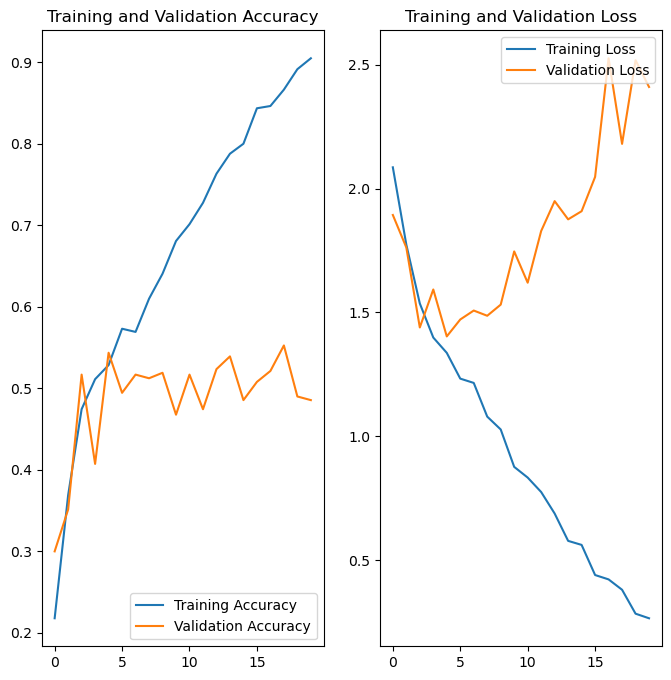

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [127]:
import Augmentor
max_images = max([len(os.listdir(train_images / i)) for i in class_names])
max_images = round(max_images / 100) * 100
for i in class_names:
    train_images_sub = train_images /  i
    classes_image_count_train = len(list(train_images_sub.glob('*.jpg')))
    augmented_image_required  = max_images - classes_image_count_train
    p = Augmentor.Pipeline(train_images_sub)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(augmented_image_required)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A584CB59D0>: 100%|██████████| 386/386 [00:00<00:00, 455.01 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A58529EF70>: 100%|██████████| 124/124 [00:00<00:00, 445.06 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A585221370>: 100%|██████████| 405/405 [00:00<00:00, 449.17 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1A582E68340>: 100%|██████████| 62/62 [00:01<00:00, 60.95 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A584FFD070>: 100%|██████████| 143/143 [00:01<00:00, 84.60 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A584FCD430>: 100%|██████████| 38/38 [00:00<00:00, 387.29 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1A585210280>: 100%|██████████| 423/423 [00:02<00:00, 205.44 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A584FE33A0>: 100%|██████████| 319/319 [00:00<00:00, 430.94 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A58520A0A0>: 100%|██████████| 361/361 [00:00<00:00, 434.07 Samples/s]                  


In [175]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_images,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                               batch_size=BATCH_SIZE, 
                                                               label_mode='categorical',
                                                               subset='training')

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [176]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_images,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                             batch_size=BATCH_SIZE, 
                                                             label_mode='categorical',
                                                             subset='validation')
 

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [177]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

In [183]:
model = tf.keras.Sequential([
    
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    #data_augmentation,
    
    #First Convulation layer
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    #Second Convulation Layer
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    #Third Convulation Layer
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    #Dropout layer with 50% Fraction of the input units to drop.
    layers.Dropout(0.5),
    
    #Flatten Layer
    ##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
    layers.Flatten(),

    #Dense Layer
    layers.Dense(128,activation='relu'),

    #Dropout layer with 25% Fraction of the input units to drop.
    layers.Dropout(0.25),

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    layers.Dense(len(class_names),activation='softmax')

])


In [184]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [185]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [186]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_20 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_64 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_65 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                               

In [187]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[reduce_lr])

Epoch 1/30
113/113 [==============================] - 43s 370ms/step - loss: 2.0762 - accuracy: 0.1803 - val_loss: 1.7133 - val_accuracy: 0.3022 - lr: 0.0010
Epoch 2/30
113/113 [==============================] - 43s 381ms/step - loss: 1.6897 - accuracy: 0.3494 - val_loss: 1.5635 - val_accuracy: 0.3944 - lr: 0.0010
Epoch 3/30
113/113 [==============================] - 46s 409ms/step - loss: 1.5646 - accuracy: 0.3850 - val_loss: 1.4973 - val_accuracy: 0.3767 - lr: 0.0010
Epoch 4/30
113/113 [==============================] - 48s 424ms/step - loss: 1.5251 - accuracy: 0.3978 - val_loss: 1.4241 - val_accuracy: 0.4467 - lr: 0.0010
Epoch 5/30
113/113 [==============================] - 50s 438ms/step - loss: 1.5115 - accuracy: 0.3992 - val_loss: 1.4448 - val_accuracy: 0.4222 - lr: 0.0010
Epoch 6/30
113/113 [==============================] - 52s 455ms/step - loss: 1.5171 - accuracy: 0.4189 - val_loss: 1.3758 - val_accuracy: 0.4811 - lr: 0.0010
Epoch 7/30
113/113 [==============================] 